# Packages

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import json
import numpy as np
import sklearn.metrics as metrics
from mapie.regression import MapieRegressor
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Configuration

In [2]:
print('display.max_rows:', pd.get_option('display.max_rows')) #60
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 60)

display.max_rows: 60


# Variables

In [3]:
dataFolderName = "UberData"    # The name of the subfolder the data is stored in.  Used to construct relative file path.
writeFiles = True #False       # Do you want to write the output files?
doRegressionLoop = True #False # Do you want to run the regression loops
debug = True #False            # Print debuging output or no? True or False


fileNamesList = [
    {"fileType": "Monthly", "fileName": "atlanta-censustracts-2019-2-All-MonthlyAggregate.csv", "year": "2019", "qtr": "2"},
    {"fileType": "Monthly", "fileName": "atlanta-censustracts-2019-3-All-MonthlyAggregate.csv", "year": "2019", "qtr": "3"},
    {"fileType": "Monthly", "fileName": "atlanta-censustracts-2019-4-All-MonthlyAggregate.csv", "year": "2019", "qtr": "4"},
    {"fileType": "Monthly", "fileName": "atlanta-censustracts-2020-1-All-MonthlyAggregate.csv", "year": "2020", "qtr": "1"},

    {"fileType": "Weekly",  "fileName": "atlanta-censustracts-2019-2-WeeklyAggregate.csv",      "year": "2019", "qtr": "2"},
    {"fileType": "Weekly",  "fileName": "atlanta-censustracts-2019-3-WeeklyAggregate.csv",      "year": "2019", "qtr": "3"},
    {"fileType": "Weekly",  "fileName": "atlanta-censustracts-2019-4-WeeklyAggregate.csv",      "year": "2019", "qtr": "4"},
    {"fileType": "Weekly",  "fileName": "atlanta-censustracts-2020-1-WeeklyAggregate.csv",      "year": "2020", "qtr": "1"},

    {"fileType": "Hourly",  "fileName": "atlanta-censustracts-2019-2-All-HourlyAggregate.csv",  "year": "2019", "qtr": "2"},
    {"fileType": "Hourly",  "fileName": "atlanta-censustracts-2019-3-All-HourlyAggregate.csv",  "year": "2019", "qtr": "3"},
    {"fileType": "Hourly",  "fileName": "atlanta-censustracts-2019-4-All-HourlyAggregate.csv",  "year": "2019", "qtr": "4"},
    {"fileType": "Hourly",  "fileName": "atlanta-censustracts-2020-1-All-HourlyAggregate.csv",  "year": "2020", "qtr": "1"},

    {"fileType": "Shapes",  "fileName": "atlanta_censustracts_0.json"}
]

# Functions

In [4]:
def regression_results(y_true, y_pred):
    # Regression metrics
    #squared_errors = (y_pred - y_true) ** 2
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(f'    Explained Variance: {round(explained_variance, 4):10.4f}')
    print(f'mean squared log error: {round(mean_squared_log_error, 4):10.4f}')
    print(f'                    R2: {round(r2, 4):10.4f}')
    print(f'                   MAE: {round(mean_absolute_error, 4):10.4f}')
    print(f'                   MSE: {round(mse, 4):10.4f}')
    print(f'                  RMSE: {round(np.sqrt(mse), 4):10.4f}')
    print(f'             Median AE: {round(median_absolute_error, 4):10.4f}')
    print()
    #print(f'Squared Error:\n {round(squared_errors, 4)}')

# Load Data

## Load Base Dataframes

In [5]:
df_mth = pd.DataFrame()
df_wk = pd.DataFrame()
df_hr = pd.DataFrame()


# Load the data from the files into the database
for f in fileNamesList:
    if debug: print(f["fileType"], f["fileName"])
    filePath = dataFolderName +"\\"+ f["fileName"]

    if f["fileType"] == "Shapes": 
        #print("Skipping Shapes File"); break
        #df_shapes = pd.read_json(filePath)
        
        # load data using Python JSON module
        with open(filePath,'r') as shapesFile:
            shapesData = json.loads(shapesFile.read())
        
        # Flatten data
        df_shapes = pd.json_normalize(shapesData, record_path=["features"], max_level=1)
        df_shapes.rename(columns={"properties.MOVEMENT_ID": "idloc", 
                                  "properties.TRACTCE": "id_tract", 
                                  "properties.GEOID":"id_geo", "properties.DISPLAY_NAME":"name"}, 
                                  inplace=True)
        if ("type" in df_shapes.columns): del df_shapes["type"]
        if ("geometry.type" in df_shapes.columns): del df_shapes["geometry.type"]
        if ("geometry.coordinates" in df_shapes.columns): del df_shapes["geometry.coordinates"]
        df_shapes = df_shapes.apply(pd.to_numeric, errors='ignore')
        
        # skip the rest of the loop
        break

    
    df_file = pd.read_csv(filePath)
    df_file["yr"] = f["year"]
    df_file["qtr"] = f["qtr"]
    df_file["type"] = f["fileType"]

    if f["fileType"] == "Hourly": df_hr = pd.concat([df_hr,df_file], axis=0, ignore_index=True)
    elif f["fileType"] == "Weekly": df_wk = pd.concat([df_wk,df_file], axis=0, ignore_index=True)
    elif f["fileType"] == "Monthly": df_mth = pd.concat([df_mth,df_file], axis=0, ignore_index=True)    

Monthly atlanta-censustracts-2019-2-All-MonthlyAggregate.csv
Monthly atlanta-censustracts-2019-3-All-MonthlyAggregate.csv
Monthly atlanta-censustracts-2019-4-All-MonthlyAggregate.csv
Monthly atlanta-censustracts-2020-1-All-MonthlyAggregate.csv
Weekly atlanta-censustracts-2019-2-WeeklyAggregate.csv
Weekly atlanta-censustracts-2019-3-WeeklyAggregate.csv
Weekly atlanta-censustracts-2019-4-WeeklyAggregate.csv
Weekly atlanta-censustracts-2020-1-WeeklyAggregate.csv
Hourly atlanta-censustracts-2019-2-All-HourlyAggregate.csv
Hourly atlanta-censustracts-2019-3-All-HourlyAggregate.csv
Hourly atlanta-censustracts-2019-4-All-HourlyAggregate.csv
Hourly atlanta-censustracts-2020-1-All-HourlyAggregate.csv
Shapes atlanta_censustracts_0.json


# Create Additional Dataframes

## Create All Rows df

In [6]:
# I'm stacking the location id's and mean travel time to have a dataframe where I can analyze the mean travel times, number of unique trips, etc.
df_allrows = \
pd.concat([df_mth[["sourceid","dstid","mean_travel_time","geometric_mean_travel_time"]],
            df_wk[["sourceid","dstid","mean_travel_time","geometric_mean_travel_time"]],
            df_hr[["sourceid","dstid","mean_travel_time","geometric_mean_travel_time"]]], 
           axis=0, ignore_index=True)

In [7]:
df_allrows

,sourceid,dstid,mean_travel_time,geometric_mean_travel_time
0,1,76,1089.88,1048.94
1,1,76,1180.25,1135.76
2,1,76,1163.92,1114.25
3,1,76,1153.63,1095.78
4,1,76,1081.49,1047.85
...,...,...,...,...
131,1,76,1176.44,1136.72
132,1,76,1059.70,1034.13
133,1,76,1146.94,1077.07
134,1,76,1104.00,1078.32


## Create Location df

In [8]:
# Unique location id's across all files
df_location = pd.DataFrame({'idloc': pd.concat([df_allrows["sourceid"],df_allrows["dstid"]],axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)})

## Create Trips df

In [9]:
# distinct trips = edge list
df_trips = df_allrows[["sourceid","dstid"]].drop_duplicates().reset_index()
if ("index" in df_trips.columns): del df_trips["index"]
#df_trips

## Create Lat Lon df
Read the latitude and longitude data file in

In [10]:
filePath = dataFolderName +"\\"+ "tl_2019_13_tract.dbf.csv"
df_latlon = pd.read_csv(filePath)
df_latlon.rename(columns={"GEOID": "id_geo", 
                          "INTPTLAT":"lat", 
                          "INTPTLON":"lon"}, 
                          inplace=True)
df_latlon = df_latlon[["id_geo","lat","lon"]]

In [11]:
df_latlon

,id_geo,lat,lon
0,13127990000,31.142730,-81.304453
1,13135050311,33.948537,-84.212621
2,13051010501,32.053575,-81.176125
3,13051011104,32.019672,-80.970837
4,13051011004,31.973473,-81.060422
...,...,...,...
1964,13089023315,33.754193,-84.066023
1965,13089023421,33.685099,-84.258787
1966,13089021411,33.866777,-84.329312
1967,13089021416,33.847324,-84.333971


# Data Summary

## Base Dataframes summary

In [12]:
print("Monthly")
print("    Shape: {:10,.0f} rows by {} columns".format(df_mth.shape[0],df_mth.shape[1]))
print("  Columns:", ' '.join(df_mth.columns))
print("    month:", sorted(df_mth["month"].unique()))
print("")

print("Weekly")
print("    Shape: {:10,.0f} rows by {} columns".format(df_wk.shape[0],df_wk.shape[1]))
print("  Columns:", ' '.join(df_wk.columns))
print("      day:", sorted(df_wk["dow"].unique()))
print("")

print("Hourly")
print("    Shape: {:10,.0f} rows by {} columns".format(df_hr.shape[0],df_hr.shape[1]))
print("  Columns:", ' '.join(df_hr.columns))
print("     hour:", sorted(df_hr["hod"].unique()))
print("")

print("Shapes")
print("    Shape: {:10,.0f} rows by {} columns".format(df_shapes.shape[0],df_shapes.shape[1]))
print("  Columns:", ' '.join(df_shapes.columns))
#print("     hour:", sorted(df_hr["hod"].unique()))
print("")

Monthly
    Shape:         12 rows by 10 columns
  Columns: sourceid dstid month mean_travel_time standard_deviation_travel_time geometric_mean_travel_time geometric_standard_deviation_travel_time yr qtr type
    month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Weekly
    Shape:         28 rows by 10 columns
  Columns: sourceid dstid dow mean_travel_time standard_deviation_travel_time geometric_mean_travel_time geometric_standard_deviation_travel_time yr qtr type
      day: [1, 2, 3, 4, 5, 6, 7]

Hourly
    Shape:         96 rows by 10 columns
  Columns: sourceid dstid hod mean_travel_time standard_deviation_travel_time geometric_mean_travel_time geometric_standard_deviation_travel_time yr qtr type
     hour: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Shapes
    Shape:          2 rows by 4 columns
  Columns: idloc id_tract id_geo name



## Additional Dataframes summaries

### All Rows summary

In [13]:

print("All Rows")
print("    Shape: {:10,.0f} rows by {} columns".format(df_allrows.shape[0],df_allrows.shape[1]))
print("  Columns:", ' '.join(df_allrows.columns))
print("")

print('mean_travel_time','\n', df_allrows["mean_travel_time"].describe().apply(lambda x: format(x, ',.2f')), sep="")
print()
print('geometric_mean_travel_time','\n', df_allrows["geometric_mean_travel_time"].describe().apply(lambda x: format(x, ',.2f')), sep="")


All Rows
    Shape:        136 rows by 4 columns
  Columns: sourceid dstid mean_travel_time geometric_mean_travel_time

mean_travel_time
count      136.00
mean     1,131.06
std         85.50
min        932.30
25%      1,077.70
50%      1,131.98
75%      1,175.62
max      1,355.69
Name: mean_travel_time, dtype: object

geometric_mean_travel_time
count      136.00
mean     1,091.15
std         79.10
min        900.77
25%      1,040.02
50%      1,094.25
75%      1,136.32
max      1,296.85
Name: geometric_mean_travel_time, dtype: object


### Location summary

In [14]:
print("Location")
#print("    Shape: {:10,.0f} rows by {} columns".format(df_locations.shape[0],df_locations.shape[1]))
print("    Shape: ", df_location.shape)
#print("  Columns:", ' '.join(df_locations.columns))
print("")

#df_locations.describe()
print(df_location)

Location
    Shape:  (2, 1)

   idloc
0      1
1     76


### Trips summary

In [15]:
print("Trips")
#print("    Shape: {:10,.0f} rows by {} columns".format(df_locations.shape[0],df_locations.shape[1]))
print("    Shape: ", df_trips.shape)
#print("  Columns:", ' '.join(df_locations.columns))
print("")

print(df_trips)

#df_trips.describe()

Trips
    Shape:  (1, 2)

   sourceid  dstid
0         1     76


### Lat Lon summary

In [16]:
print("Lat Lon")
print("    Shape: {:10,.0f} rows by {} columns".format(df_latlon.shape[0],df_latlon.shape[1]))
print("  Columns:", ' '.join(df_latlon.columns))
print("")
print(df_latlon)

Lat Lon
    Shape:      1,969 rows by 3 columns
  Columns: id_geo lat lon

           id_geo        lat        lon
0     13127990000  31.142730 -81.304453
1     13135050311  33.948537 -84.212621
2     13051010501  32.053575 -81.176125
3     13051011104  32.019672 -80.970837
4     13051011004  31.973473 -81.060422
...           ...        ...        ...
1964  13089023315  33.754193 -84.066023
1965  13089023421  33.685099 -84.258787
1966  13089021411  33.866777 -84.329312
1967  13089021416  33.847324 -84.333971
1968  13089021504  33.813115 -84.315907

[1969 rows x 3 columns]


# Correlation mean_travel_time geometric_mean_travel_time

In [17]:
#df_allrows["mean_travel_time"].hist()
#sns.histplot(df_allrows["mean_travel_time"], color="black", legend=True, alpha=0.5)
#sns.histplot(df_allrows["geometric_mean_travel_time"], color="blue", legend=True, alpha=0.5)

#dat = sns.load_dataset(df_allrows)
#sns.histplot(data=df_allrows[["mean_travel_time","geometric_mean_travel_time"]], alpha=0.5)

![](./IMG/hist_mtt_gmtt.png)

In [18]:
cor = df_allrows["mean_travel_time"].corr(df_allrows["geometric_mean_travel_time"])
print("The correlation between mean_travel_time and geometric_mean_travel_time is {:.4f}".format(cor))

The correlation between mean_travel_time and geometric_mean_travel_time is 0.9885


# How many observations do we typically have for each trip (sourceid:dstid pair)?

In [19]:
df_trip_row_count = df_allrows.groupby(["sourceid","dstid"])["mean_travel_time"].agg('size').reset_index()

Stats about the count of observations per trip.  How much data do we have on each trip?
       count_obs
count        1.0
mean       136.0
std          NaN
min        136.0
25%        136.0
50%        136.0
75%        136.0
max        136.0


Text(0.5, 1.0, 'Histogram of counts of observations per trip')

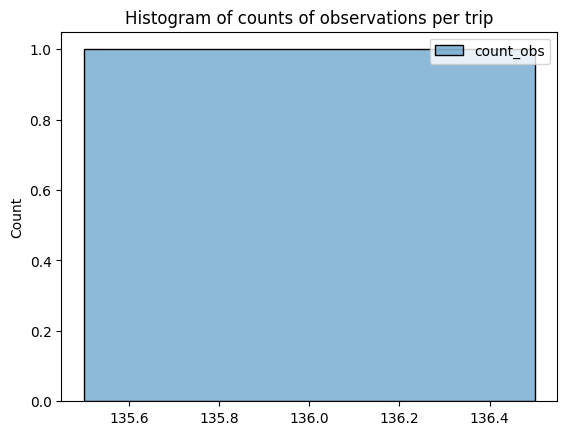

In [20]:
df_trip_row_count.rename(columns={"mean_travel_time": "count_obs"}, inplace=True)
#df_trip_row_count
print("Stats about the count of observations per trip.  How much data do we have on each trip?")
print(df_trip_row_count[["count_obs"]].describe())
sns.histplot(df_trip_row_count[["count_obs"]]).set_title('Histogram of counts of observations per trip')

**239,290** unique trips

**~80,000** with **136** observations.  (24 hours * 4 quarters, 7 days * 4 quarters, 12 months)

# One Trip Values (1,76)

In [21]:
# find one with 136 obs
df_trip_row_count.head(10)
# 1,76

,sourceid,dstid,count_obs
0,1,76,136


In [22]:

df_hr.query('sourceid==1 & dstid==76').sort_values(['hod','yr','qtr'])

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,yr,qtr,type
20,1,76,0,980.22,224.98,955.49,1.25,2019,2,Hourly
36,1,76,0,1025.21,322.41,975.20,1.37,2019,3,Hourly
54,1,76,0,1098.38,354.13,1048.82,1.35,2019,4,Hourly
88,1,76,0,932.30,258.76,900.77,1.29,2020,1,Hourly
6,1,76,1,1109.38,337.21,1056.81,1.37,2019,2,Hourly
...,...,...,...,...,...,...,...,...,...,...
90,1,76,22,1042.11,221.16,1019.13,1.24,2020,1,Hourly
8,1,76,23,1078.69,331.64,1027.67,1.37,2019,2,Hourly
45,1,76,23,1003.27,245.25,976.57,1.26,2019,3,Hourly
66,1,76,23,1213.44,366.56,1166.56,1.31,2019,4,Hourly


In [23]:
print('Shape:', df_wk.query('sourceid==1 & dstid==76').sort_values(['dow','yr','qtr']).shape)
df_wk.query('sourceid==1 & dstid==76').sort_values(['dow','yr','qtr'])

Shape: (28, 10)


,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,yr,qtr,type
4,1,76,1,1156.98,356.86,1109.74,1.33,2019,2,Weekly
10,1,76,1,1160.98,324.76,1120.43,1.30,2019,3,Weekly
16,1,76,1,1144.13,320.44,1108.95,1.27,2019,4,Weekly
22,1,76,1,1183.36,346.90,1137.50,1.32,2020,1,Weekly
5,1,76,2,1192.07,392.55,1139.81,1.34,2019,2,Weekly
11,1,76,2,1160.19,348.22,1116.17,1.31,2019,3,Weekly
18,1,76,2,1130.68,365.22,1085.54,1.32,2019,4,Weekly
23,1,76,2,1202.11,359.27,1153.41,1.33,2020,1,Weekly
6,1,76,3,1159.04,349.76,1112.28,1.33,2019,2,Weekly
8,1,76,3,1148.27,416.73,1096.26,1.33,2019,3,Weekly


In [24]:
print('Shape:',df_mth.query('sourceid==1 & dstid==76').sort_values(['month','yr','qtr']).shape)
df_mth.query('sourceid==1 & dstid==76').sort_values(['month','yr','qtr'])

Shape: (12, 10)


,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,yr,qtr,type
9,1,76,1,1118.77,310.77,1080.84,1.29,2020,1,Monthly
11,1,76,2,1175.35,324.83,1133.58,1.31,2020,1,Monthly
10,1,76,3,1169.88,335.55,1128.02,1.30,2020,1,Monthly
1,1,76,4,1180.25,345.23,1135.76,1.31,2019,2,Monthly
2,1,76,5,1163.92,425.68,1114.25,1.32,2019,2,Monthly
0,1,76,6,1089.88,328.90,1048.94,1.31,2019,2,Monthly
4,1,76,7,1081.49,296.74,1047.85,1.28,2019,3,Monthly
5,1,76,8,1141.28,362.89,1099.39,1.30,2019,3,Monthly
3,1,76,9,1153.63,409.06,1095.78,1.41,2019,3,Monthly
6,1,76,10,1152.78,354.33,1106.64,1.32,2019,4,Monthly


## Trip 1,76 data summary
* 96 rows from hourly    - all 24 hours * all 4 quarters
* 28 rows from weekly    - all  7 days  * all 4 quarters
* 12 rows from quarterly - all 12 months from their respective quarters

In [25]:
print("Stats about the observations of trip {1,76}")
df_allrows.query('sourceid==1 & dstid==76')["mean_travel_time"].describe()

Stats about the observations of trip {1,76}


count     136.000000
mean     1131.064706
std        85.500231
min       932.300000
25%      1077.700000
50%      1131.980000
75%      1175.622500
max      1355.690000
Name: mean_travel_time, dtype: float64

# Analysis File Build

In [26]:
#df_shapes.query('idloc==1')
df_shapes

,idloc,id_tract,id_geo,name
0,1,23315,13089023315,Census Tract 233.15
1,76,21912,13089021912,Census Tract 219.12


## Location
Suplement the Location data with degout, degin

In [27]:
df_trips.query('sourceid==1')

,sourceid,dstid
0,1,76


In [28]:
df_degout = df_trips.groupby(["sourceid"]).agg(degout=('sourceid', 'size')).reset_index()
df_degout

,sourceid,degout
0,1,1


In [29]:
df_degin = df_trips.groupby(["dstid"]).agg(degin=('dstid', 'size')).reset_index()
df_degin

,dstid,degin
0,76,1


Join the dataframes together before writing to file

In [30]:
#print(df_locations)
#print(df_degin)
#print(df_degout)
#df_locations.set_index('idloc').join(df_degin.set_index('dstid')).join(df_degout.set_index('sourceid')).loc[[1,2,3,4]]
df_location = df_location.set_index('idloc') \
    .join(df_shapes.set_index('idloc')) \
    .join(df_degin.set_index('dstid')) \
    .join(df_degout.set_index('sourceid')) \
    .sort_values(by=['idloc']).reset_index()

In [31]:
df_location

,idloc,id_tract,id_geo,name,degin,degout
0,1,23315,13089023315,Census Tract 233.15,NaN,1.0
1,76,21912,13089021912,Census Tract 219.12,1.0,NaN


In [32]:
df_location = df_location.set_index('id_geo').join(df_latlon.set_index('id_geo')).reset_index()

In [33]:
df_location = df_location.set_index('idloc').reset_index()

In [34]:
df_location

,idloc,id_geo,id_tract,name,degin,degout,lat,lon
0,1,13089023315,23315,Census Tract 233.15,NaN,1.0,33.754193,-84.066023
1,76,13089021912,21912,Census Tract 219.12,1.0,NaN,33.835545,-84.158713


Write location file

In [35]:
if writeFiles:
    # write file
    from datetime import datetime
    strnow = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = "data_location_" + strnow + ".csv"
    df_location.to_csv(filename, index=False)

## Trip
### Calculations for trip data.  A trip is a location pair.

In [36]:
df_trip_a = df_allrows.groupby(["sourceid","dstid"]).agg(ttmin=('mean_travel_time', 'min'), ttmean=('mean_travel_time', 'mean'), ttmax=('mean_travel_time', 'max')).reset_index()
df_trip_a

,sourceid,dstid,ttmin,ttmean,ttmax
0,1,76,932.3,1131.064706,1355.69


In [37]:
df_trip_b = df_allrows.groupby(["sourceid","dstid"])["mean_travel_time"].quantile(0.95).reset_index()
df_trip_b.rename(columns={"mean_travel_time": "ttnfp"}, inplace=True)
df_trip_b

,sourceid,dstid,ttnfp
0,1,76,1292.5675


In [38]:
df_trip = df_trip_a.set_index(['sourceid','dstid']).join(df_trip_b.set_index(['sourceid','dstid'])).reset_index()

# The buffer index is computed as the difference between the 95th percentile travel time and average travel time, divided by the average travel time
df_trip["idxbf"] = ( df_trip["ttnfp"] - df_trip["ttmean"] )  / df_trip["ttmean"]

# The planning time index is computed as the 95th percentile travel time divided by the free-flow travel time.  Free-flow travel time is min travel time.
df_trip["idxtm"] = df_trip["ttnfp"] / df_trip["ttmin"]

# Buffer time – The extra time required (i.e., calculated as the difference between the 95th percentile travel time and the average travel time).
df_trip["tmbf"] = ( df_trip["ttnfp"] - df_trip["ttmean"] )

# Planning time – The total travel time, which includes buffer time (i.e., calculated as the 95th percentile travel time).
df_trip["tmplan"] = ( df_trip["tmbf"] + df_trip["ttmean"] )

## fake these columns for now ... will be regression interval results later
#df_trip["intvlmin"] = df_trip["ttmin"]
#df_trip["intvlmax"] = df_trip["ttmax"]

In [39]:
df_trip

,sourceid,dstid,ttmin,ttmean,ttmax,ttnfp,idxbf,idxtm,tmbf,tmplan
0,1,76,932.3,1131.064706,1355.69,1292.5675,0.142788,1.386429,161.502794,1292.5675


# Regression

## Build regression dataFrame

In [40]:
# I'm stacking the location id's and mean travel time to have a dataframe where I can analyze the mean travel times, number of unique trips, etc.
df_regression = \
pd.concat([df_mth[["sourceid","dstid","mean_travel_time","type","month"]],
            df_wk[["sourceid","dstid","mean_travel_time","type","dow"]],
            df_hr[["sourceid","dstid","mean_travel_time","type","hod"]]], 
           axis=0, ignore_index=True)

## Feature Engineering

In [41]:
# isAMRushHour (6a-8a) xxx Weekdays only, can't, don't have dow and hod on same row.
# isPMRushHour (3p-6p)
# isWeekday
df_regression["isAMRushHour"] = df_regression["hod"].between(6.0, 8.0) #& df_regression["dow"].between(1.0, 5.0)
df_regression["isPMRushHour"] = df_regression["hod"].between(15.0, 18.0) #& df_regression["dow"].between(1.0, 5.0)
df_regression["isWeekday"] = df_regression["dow"].between(1.0, 5.0)
df_regression["Ones"] = 1

thisTrip_src = 1
thisTrip_dst = 76

# isWeekend - don't need.  Opposite of isWeekday
#df_regression["isWeekend"] = df_regression["dow"].between(6.0, 7.0)

In [42]:
#df_regression.query('sourceid==1 & dstid==76 and dow >= 1.0 and dow <= 5.0')
#df_regression.query('sourceid==1 & dstid==76 and hod >= 6.0 and hod <= 8.0')

# Weekday am rush
df_regression.query(f'sourceid=={thisTrip_src} & dstid=={thisTrip_dst} and hod >= 6.0 and hod <= 8.0 and dow >= 1.0 and dow <= 5.0')


,sourceid,dstid,mean_travel_time,type,month,dow,hod,isAMRushHour,isPMRushHour,isWeekday,Ones


In the rows, we don't know the combinations of data fields.  We don't know if it's a weekday and what hour of day it is.

In [43]:
df_regression

,sourceid,dstid,mean_travel_time,type,month,dow,hod,isAMRushHour,isPMRushHour,isWeekday,Ones
0,1,76,1089.88,Monthly,6.0,NaN,NaN,False,False,False,1
1,1,76,1180.25,Monthly,4.0,NaN,NaN,False,False,False,1
2,1,76,1163.92,Monthly,5.0,NaN,NaN,False,False,False,1
3,1,76,1153.63,Monthly,9.0,NaN,NaN,False,False,False,1
4,1,76,1081.49,Monthly,7.0,NaN,NaN,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...
131,1,76,1176.44,Hourly,NaN,NaN,2.0,False,False,False,1
132,1,76,1059.70,Hourly,NaN,NaN,12.0,False,False,False,1
133,1,76,1146.94,Hourly,NaN,NaN,21.0,False,False,False,1
134,1,76,1104.00,Hourly,NaN,NaN,1.0,False,False,False,1


In [44]:
# train
#print(df_regression.query('sourceid==1 & dstid==76').columns)
#['sourceid', 'dstid', 'type', 'month', 'dow', 'hod', 'isAMRushHour', 'isPMRushHour', 'isWeekday', 'isWeekend']
#thisTrip_y = df_regression.query('sourceid==1 & dstid==76')['mean_travel_time']
thisTrip_y = df_regression.query(f'sourceid=={thisTrip_src} & dstid=={thisTrip_dst}')['mean_travel_time']
display(thisTrip_y)

#keepX = ['sourceid', 'dstid', 'isAMRushHour', 'isPMRushHour', 'isWeekday', 'isWeekend']
keepX = ['sourceid', 'dstid', 'isAMRushHour', 'isPMRushHour', 'isWeekday', 'Ones']
#thisTrip_x = df_regression.query('sourceid==1 & dstid==76')[keepX]
thisTrip_x = df_regression.query(f'sourceid=={thisTrip_src} & dstid=={thisTrip_dst}')[keepX]
display(thisTrip_x)

0      1089.88
1      1180.25
2      1163.92
3      1153.63
4      1081.49
        ...   
131    1176.44
132    1059.70
133    1146.94
134    1104.00
135    1138.43
Name: mean_travel_time, Length: 136, dtype: float64

,sourceid,dstid,isAMRushHour,isPMRushHour,isWeekday,Ones
0,1,76,False,False,False,1
1,1,76,False,False,False,1
2,1,76,False,False,False,1
3,1,76,False,False,False,1
4,1,76,False,False,False,1
...,...,...,...,...,...,...
131,1,76,False,False,False,1
132,1,76,False,False,False,1
133,1,76,False,False,False,1
134,1,76,False,False,False,1


## Regression proof of concept
### isAMRushHour, isPMRushHour, isWeekday

In [45]:
reg = LinearRegression().fit(thisTrip_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], thisTrip_y)

In [46]:
#print(f'{reg = }')
print(f'      Intercept: {reg.intercept_}')
print(f'Regression coef: {reg.coef_}')
print(f'          Names: {reg.feature_names_in_}')
print(f'     N Features: {reg.n_features_in_}')
print(f'           Rank: {reg.rank_ = }')
print(f'     Parameters: {reg.get_params()}')

      Intercept: 1094.2013636363638
Regression coef: [160.69363636 103.36988636  71.55863636]
          Names: ['isAMRushHour' 'isPMRushHour' 'isWeekday']
     N Features: 3
           Rank: reg.rank_ = 3
     Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


In [47]:
y_pred = reg.predict(thisTrip_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']])
print(y_pred)

[1094.20136364 1094.20136364 1094.20136364 1094.20136364 1094.20136364
 1094.20136364 1094.20136364 1094.20136364 1094.20136364 1094.20136364
 1094.20136364 1094.20136364 1165.76       1094.20136364 1165.76
 1094.20136364 1165.76       1165.76       1165.76       1165.76
 1165.76       1094.20136364 1165.76       1165.76       1165.76
 1094.20136364 1165.76       1094.20136364 1165.76       1165.76
 1165.76       1094.20136364 1165.76       1094.20136364 1165.76
 1165.76       1165.76       1094.20136364 1165.76       1165.76
 1094.20136364 1094.20136364 1094.20136364 1094.20136364 1197.57125
 1094.20136364 1094.20136364 1094.20136364 1094.20136364 1094.20136364
 1254.895      1094.20136364 1094.20136364 1094.20136364 1197.57125
 1197.57125    1094.20136364 1094.20136364 1094.20136364 1197.57125
 1094.20136364 1254.895      1254.895      1094.20136364 1197.57125
 1094.20136364 1094.20136364 1094.20136364 1197.57125    1094.20136364
 1197.57125    1254.895      1094.20136364 1094.201363

In [48]:
regression_results(thisTrip_y, y_pred)

print(f' R2: {reg.score(thisTrip_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], thisTrip_y)}')
print(f' R2: {metrics.r2_score(thisTrip_y, y_pred):.4f}')

# The mean squared error
print(f" MSE: {metrics.mean_squared_error(thisTrip_y, y_pred):.2f}")

# Squared Error
squared_errors = (y_pred - thisTrip_y) ** 2
#print(squared_errors)
print(f' MSE: {squared_errors.mean()}')

    Explained Variance:     0.4037
mean squared log error:     0.0035
                    R2:     0.4037
                   MAE:    51.7993
                   MSE:  4326.8593
                  RMSE:    65.7789
             Median AE:    40.2863

 R2: 0.4037294836722225
 R2: 0.4037
 MSE: 4326.86
 MSE: 4326.8593346423795


### References / Links

In [49]:
# Prediction Intervals
# https://how-to-data.org/how-to-compute-a-confidence-interval-for-a-regression-coefficient-in-python-using-statsmodels/
# https://stackoverflow.com/questions/61292464/get-confidence-interval-from-sklearn-linear-regression-in-python
# https://towardsdatascience.com/prediction-intervals-in-python-64b992317b1a
# https://mapie.readthedocs.io/en/latest/

# Regression with no predictors
# https://stackoverflow.com/questions/9057898/is-it-possible-to-fit-a-linear-model-with-only-a-response-variable
# http://www.philender.com/courses/linearmodels/notes1/nopredict.html

### Failed attempt at calculating prediction intervals

In [50]:
#https://stackoverflow.com/questions/63165775/how-to-calculate-the-confidence-intervals-for-prediction-in-regression-and-also
confidence = 0.95
#squared_errors = (<<predicted values>> - <<true y_test values>>) ** 2
squared_errors = (y_pred - thisTrip_y) ** 2
#print(squared_errors)
print(f'Mean Squared Errors: {squared_errors.mean()}')
CI = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

print(f'      Mean Response: {thisTrip_y.mean()}')
print(f'    Mean Prediction: {y_pred.mean()}')
print(f'      Prediction CI: {CI}')
print()
print('!!!!!!!!!!!!')
print('!!! FAIL !!!')
print('!!!!!!!!!!!!')

Mean Squared Errors: 4326.8593346423795
      Mean Response: 1131.064705882353
    Mean Prediction: 1131.0647058823533
      Prediction CI: [57.03824879 73.48712026]

!!!!!!!!!!!!
!!! FAIL !!!
!!!!!!!!!!!!


### Mapie to calculate Prediction Intervals

In [51]:
regressor = LinearRegression()
mapie_regressor = MapieRegressor(estimator=regressor, method='plus', cv=5)
mapie_regressor = mapie_regressor.fit(thisTrip_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], thisTrip_y)

# make prediction set
predict_x = pd.DataFrame([[thisTrip_src,thisTrip_dst,True,False,True,'Morning Rush Hour'],
                          [thisTrip_src,thisTrip_dst,False,True,True,'Evening Rush Hour'],
                          [thisTrip_src,thisTrip_dst,False,False,True,'Weekday Not Rush Hour'],
                          [thisTrip_src,thisTrip_dst,False,False,False,'Weekend']
                          ])
predict_x.columns = ['sourceid','dstid','isAMRushHour', 'isPMRushHour', 'isWeekday', 'Case Name']
display(predict_x)

#y_pred_mapie, y_pis = mapie_regressor.predict(thisTrip_x, alpha=[0.05])
y_pred_mapie, y_pis = mapie_regressor.predict(predict_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], alpha=[0.05])

#y_pis.shape
#y_pred
#list(zip(y_pred_mapie,y_pis))
#print(y_pis,'\n\n')
#for CI in y_pis:
#    print(CI[0],CI[1])

PIs = [[l,u] for l,u in y_pis[:,0:2,0]]
list(zip(y_pred_mapie,PIs))

,sourceid,dstid,isAMRushHour,isPMRushHour,isWeekday,Case Name
0,1,76,True,False,True,Morning Rush Hour
1,1,76,False,True,True,Evening Rush Hour
2,1,76,False,False,True,Weekday Not Rush Hour
3,1,76,False,False,False,Weekend


[(1326.4536363636366, [1178.6277855706387, 1474.8355151515152]),
 (1269.1298863636366, [1124.5919004524887, 1404.296564102564]),
 (1165.7600000000002, [1019.7746190476191, 1310.8044281045752]),
 (1094.2013636363638, [950.99, 1242.594411764706])]

In [52]:
df_regression_results = pd.DataFrame(PIs)
df_regression_results.columns = ['PI_lwr','PI_upr']
#pd.concat([predict_x,pd.Series(y_pred_mapie),df_regression_results], axis=1, ignore_index=True)
df_regression_results = pd.concat([predict_x,pd.Series(y_pred_mapie, name='Pred'),df_regression_results], axis=1)

In [53]:
df_regression_results

,sourceid,dstid,isAMRushHour,isPMRushHour,isWeekday,Case Name,Pred,PI_lwr,PI_upr
0,1,76,True,False,True,Morning Rush Hour,1326.453636,1178.627786,1474.835515
1,1,76,False,True,True,Evening Rush Hour,1269.129886,1124.591900,1404.296564
2,1,76,False,False,True,Weekday Not Rush Hour,1165.760000,1019.774619,1310.804428
3,1,76,False,False,False,Weekend,1094.201364,950.990000,1242.594412


In [54]:
df_forfile = df_regression_results.pivot(index=['sourceid','dstid'], columns="Case Name", values=['Pred', 'PI_lwr','PI_upr'])
df_forfile.reset_index(inplace=True)
df_forfile.columns = ['sourceid','dstid','p_pm','p_am','p_wd','p_we',
                      'p_pm_lwr','p_am_lwr','p_wd_lwr','p_we_lwr',
                      'p_pm_upr','p_am_upr','p_wd_upr','p_we_upr']
df_forfile

,sourceid,dstid,p_pm,p_am,p_wd,p_we,p_pm_lwr,p_am_lwr,p_wd_lwr,p_we_lwr,p_pm_upr,p_am_upr,p_wd_upr,p_we_upr
0,1,76,1269.129886,1326.453636,1165.76,1094.201364,1124.5919,1178.627786,1019.774619,950.99,1404.296564,1474.835515,1310.804428,1242.594412


In [55]:
#reg = LinearRegression().fit(thisTrip_x[['Ones']], thisTrip_y)
#y_pred = reg.predict(thisTrip_x[['Ones']])

# Regression for All Trips
loop trips
* specific trip, get observations
* train
* predict
* get 95% Prediction Interval
* store

In [56]:
df_trips.shape

(1, 2)

In [57]:
# make prediction set
predict_x = pd.DataFrame([[True,False,True,'Morning Rush Hour'],
                          [False,True,True,'Evening Rush Hour'],
                          [False,False,True,'Weekday Not Rush Hour'],
                          [False,False,False,'Weekend']
                          ])
predict_x.columns = ['isAMRushHour', 'isPMRushHour', 'isWeekday', 'Case Name']
display(predict_x)

,isAMRushHour,isPMRushHour,isWeekday,Case Name
0,True,False,True,Morning Rush Hour
1,False,True,True,Evening Rush Hour
2,False,False,True,Weekday Not Rush Hour
3,False,False,False,Weekend


## Regression Function

In [58]:
def doRegression(thisTrip):    
    
    #print(f'Source ID:{thisTrip.sourceid:4}  Destination ID:{thisTrip.dstid:4}')
    
    df_thisTrip = df_regression.query(f'sourceid=={thisTrip.sourceid} & dstid=={thisTrip.dstid}')

    thisTrip_y = df_thisTrip['mean_travel_time']
    #display(thisTrip_y)
    
    keepX = ['isAMRushHour', 'isPMRushHour', 'isWeekday']
    thisTrip_x = df_thisTrip[keepX]
    #display(thisTrip_x)
    #print(f'Shapes  y:{thisTrip_y.shape[0]:4}  x:{thisTrip_x.shape[0]:4}, {thisTrip_x.shape[1]}')

    # make prediction set                                         AM     PM     Weekday
    predict_x = pd.DataFrame([[thisTrip.sourceid, thisTrip.dstid, True,  False, True,  'Morning Rush Hour'],
                              [thisTrip.sourceid, thisTrip.dstid, False, True,  True,  'Evening Rush Hour'],
                              [thisTrip.sourceid, thisTrip.dstid, False, False, True,  'Weekday Not Rush Hour'],
                              [thisTrip.sourceid, thisTrip.dstid, False, False, False, 'Weekend']
                              ])
    predict_x.columns = ['sourceid','dstid','isAMRushHour', 'isPMRushHour', 'isWeekday', 'Case Name']

    alpha = 0.05
    regressor = LinearRegression()

    y_len = len(thisTrip_y)
    #cvSize = 5 if y_len > 5 else y_len - 1
    if (y_len > 20 ):
        mapie = MapieRegressor(estimator=regressor, method='plus', cv=5)
        mapie.fit(thisTrip_x, thisTrip_y)
        y_pred, y_pis = mapie.predict(predict_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], alpha=alpha)
    else:
        #mapie = MapieRegressor(estimator=regressor, method='plus', cv=-1)
        #mapie.fit(thisTrip_x, thisTrip_y)
        #y_pred, y_pis = mapie.predict(predict_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], alpha=alpha)
        return None

    PIs = [[l,u] for l,u in y_pis[:,0:2,0]]
    df_regression_results = pd.DataFrame(PIs)
    df_regression_results.columns = ['PI_lwr','PI_upr']
    df_regression_results = pd.concat([predict_x, pd.Series(y_pred, name='Pred'), df_regression_results], axis=1)

    df_forfile = df_regression_results.pivot(index=['sourceid','dstid'], columns="Case Name", values=['Pred', 'PI_lwr','PI_upr'])
    df_forfile.reset_index(inplace=True)
    df_forfile.columns = ['sourceid','dstid','p_pm','p_am','p_wd','p_we',
                      'p_pm_lwr','p_am_lwr','p_wd_lwr','p_we_lwr',
                      'p_pm_upr','p_am_upr','p_wd_upr','p_we_upr']
    return df_forfile

In [59]:
def doRegressionSmall(thisTrip):    
    
    #print(f'Source ID:{thisTrip.sourceid:4}  Destination ID:{thisTrip.dstid:4}')
    
    df_thisTrip = df_regression.query(f'sourceid=={thisTrip.sourceid} & dstid=={thisTrip.dstid}')

    thisTrip_y = df_thisTrip['mean_travel_time']
    #display(thisTrip_y)
    
    keepX = ['isAMRushHour', 'isPMRushHour', 'isWeekday']
    thisTrip_x = df_thisTrip[keepX]
    #display(thisTrip_x)
    #print(f'Shapes  y:{thisTrip_y.shape[0]:4}  x:{thisTrip_x.shape[0]:4}, {thisTrip_x.shape[1]}')

    # make prediction set                                         AM     PM     Weekday
    predict_x = pd.DataFrame([[thisTrip.sourceid, thisTrip.dstid, True,  False, True,  'Morning Rush Hour'],
                              [thisTrip.sourceid, thisTrip.dstid, False, True,  True,  'Evening Rush Hour'],
                              [thisTrip.sourceid, thisTrip.dstid, False, False, True,  'Weekday Not Rush Hour'],
                              [thisTrip.sourceid, thisTrip.dstid, False, False, False, 'Weekend']
                              ])
    predict_x.columns = ['sourceid','dstid','isAMRushHour', 'isPMRushHour', 'isWeekday', 'Case Name']

    alpha = 0.05
    regressor = LinearRegression()

    y_len = len(thisTrip_y)
    #cvSize = 5 if y_len > 5 else y_len - 1
    if (y_len <= 20 ):
        mapie = MapieRegressor(estimator=regressor, method='naive')
        mapie.fit(thisTrip_x, thisTrip_y)
        y_pred = mapie.predict(thisTrip_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']])

        #https://towardsdatascience.com/mapie-explained-exactly-how-you-wished-someone-explained-to-you-78fb8ce81ff3
        # Compute Absolute Error
        y_error = np.abs(thisTrip_y - y_pred)

        #calculate the 1 - alpha quantile
        quantile = y_error.quantile(q=1-alpha, interpolation='higher')
        
        y_pred = mapie.predict(predict_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']])
        y_pis = [[y_pred - quantile,y_pred + quantile] for y_pred in y_pred]

    else:
        #mapie = MapieRegressor(estimator=regressor, method='plus', cv=-1)
        #mapie.fit(thisTrip_x, thisTrip_y)
        #y_pred, y_pis = mapie.predict(predict_x[['isAMRushHour', 'isPMRushHour', 'isWeekday']], alpha=alpha)
        return None

    #PIs = [[l,u] for l,u in y_pis[:,0:2,0]]
    #df_regression_results = pd.DataFrame(PIs)
    df_regression_results = pd.DataFrame(y_pis)
    df_regression_results.columns = ['PI_lwr','PI_upr']
    df_regression_results = pd.concat([predict_x, pd.Series(y_pred, name='Pred'), df_regression_results], axis=1)

    df_forfile = df_regression_results.pivot(index=['sourceid','dstid'], columns="Case Name", values=['Pred', 'PI_lwr','PI_upr'])
    df_forfile.reset_index(inplace=True)
    df_forfile.columns = ['sourceid','dstid','p_pm','p_am','p_wd','p_we',
                      'p_pm_lwr','p_am_lwr','p_wd_lwr','p_we_lwr',
                      'p_pm_upr','p_am_upr','p_wd_upr','p_we_upr']
    return df_forfile

## Regression Loop

In [60]:
# Regular trips, > 20 observations
#==================================
# List of dataFrame
fileResults = []

predFile = 'pred.out'

with open(predFile, "w") as text_file:
    text_file.write('sourceid,dstid,p_pm,p_am,p_wd,p_we,p_pm_lwr,p_am_lwr,p_wd_lwr,p_we_lwr,p_pm_upr,p_am_upr,p_wd_upr,p_we_upr' + '\n')

cantFile = 'cant.out'

#f_pred = open(predFile,'a')

if doRegressionLoop:
    for thisTrip in df_trips.itertuples():
    #for thisTrip in df_trips.head(10).itertuples():
        #if(thisTrip.Index > 0 and thisTrip.Index % 10 == 0):
        if(thisTrip.Index > 0 and thisTrip.Index % 10 == 0):
            print(f'{thisTrip.Index:6}')
        else:
            print(f'{thisTrip.Index:6}', end=", ")
            
        retvalue = doRegression(thisTrip)
        #print(retvalue)
        fileResults.append(retvalue)
    
        if retvalue is None:
            with open(cantFile,'a') as f_cant:
                f_cant.write(f'{thisTrip.sourceid},{thisTrip.dstid}\n')
        else:
            retvalue.to_csv(predFile,mode='a', index=False, header=False)

     0, 

In [61]:
# Small trips, <= 20 observations
#==================================
# List of dataFrame
fileResults = []

predFile = 'pred2.out'
cantFile = 'cant2.out'

#f_pred = open(predFile,'a')

if doRegressionLoop:
    for thisTrip in df_trips.itertuples():
    #for thisTrip in df_trips.head(10).itertuples():
        #if(thisTrip.Index > 0 and thisTrip.Index % 10 == 0):
        if(thisTrip.Index > 0 and thisTrip.Index % 10 == 0):
            print(f'{thisTrip.Index:6}')
        else:
            print(f'{thisTrip.Index:6}', end=", ")
            
        retvalue = doRegressionSmall(thisTrip)
        #print(retvalue)
        fileResults.append(retvalue)

        if retvalue is None:
            #with open(cantFile,'a') as f_cant:
            #    f_cant.write(f'{thisTrip.sourceid},{thisTrip.dstid}\n')
            pass
        else:
            retvalue.to_csv(predFile,mode='a', index=False, header=False)

     0, 

## Create Prediction df

In [62]:
# Predictions with more than 20 observations
filePath = "pred.out"
df_pred1 = pd.read_csv(filePath)

## Predictions with 20 or fewer observations
#filePath = "pred2.out"
#df_pred2 = pd.read_csv(filePath)

#df_predictions = pd.concat([df_pred1, df_pred2], axis=0).reset_index(drop=True)[['sourceid', 'dstid', 
#                      'p_pm', 'p_pm_lwr', 'p_pm_upr', 
#                      'p_am', 'p_am_lwr', 'p_am_upr', 
#                      'p_wd', 'p_wd_lwr', 'p_wd_upr',
#                      'p_we', 'p_we_lwr', 'p_we_upr' ]]

df_predictions = df_pred1[['sourceid', 'dstid', 
                      'p_pm', 'p_pm_lwr', 'p_pm_upr', 
                      'p_am', 'p_am_lwr', 'p_am_upr', 
                      'p_wd', 'p_wd_lwr', 'p_wd_upr',
                      'p_we', 'p_we_lwr', 'p_we_upr' ]]

In [63]:
df_predictions

,sourceid,dstid,p_pm,p_pm_lwr,p_pm_upr,p_am,p_am_lwr,p_am_upr,p_wd,p_wd_lwr,p_wd_upr,p_we,p_we_lwr,p_we_upr
0,1,76,1269.129886,1129.252746,1414.762941,1326.453636,1180.513195,1467.591988,1165.76,1025.293286,1310.147568,1094.201364,953.44,1235.54


### Predictions Summary

In [64]:
print("Predictions" + "\n")
print("    Shape: {:10,.0f} rows by {} columns".format(df_predictions.shape[0],df_predictions.shape[1]))
print("  Columns:", ' '.join(df_predictions.columns))
print("")
display(df_predictions)

Predictions

    Shape:          1 rows by 14 columns
  Columns: sourceid dstid p_pm p_pm_lwr p_pm_upr p_am p_am_lwr p_am_upr p_wd p_wd_lwr p_wd_upr p_we p_we_lwr p_we_upr



,sourceid,dstid,p_pm,p_pm_lwr,p_pm_upr,p_am,p_am_lwr,p_am_upr,p_wd,p_wd_lwr,p_wd_upr,p_we,p_we_lwr,p_we_upr
0,1,76,1269.129886,1129.252746,1414.762941,1326.453636,1180.513195,1467.591988,1165.76,1025.293286,1310.147568,1094.201364,953.44,1235.54


### Join Predictions

In [65]:
df_trip = df_trip.set_index(['sourceid','dstid']).join(df_predictions.set_index(['sourceid','dstid'])).sort_values(by=['sourceid','dstid']).reset_index()

In [66]:
display(df_trip)

,sourceid,dstid,ttmin,ttmean,ttmax,ttnfp,idxbf,idxtm,tmbf,tmplan,...,p_pm_upr,p_am,p_am_lwr,p_am_upr,p_wd,p_wd_lwr,p_wd_upr,p_we,p_we_lwr,p_we_upr
0,1,76,932.3,1131.064706,1355.69,1292.5675,0.142788,1.386429,161.502794,1292.5675,...,1414.762941,1326.453636,1180.513195,1467.591988,1165.76,1025.293286,1310.147568,1094.201364,953.44,1235.54


### Convert to minutes

In [67]:
#df_trip.columns
#['sourceid', 'dstid', 
# 'ttmin', 'ttmean', 'ttmax', 'ttnfp', 'idxbf','idxtm', 'tmbf', 'tmplan', 
# 'p_pm', 'p_pm_lwr', 'p_pm_upr', 
# 'p_am', 'p_am_lwr', 'p_am_upr', 
# 'p_wd', 'p_wd_lwr', 'p_wd_upr', 
# 'p_we', 'p_we_lwr', 'p_we_upr']

def convertToMinutesAndRound(x):
    return round(x / 60, 2)

df_trip[['ttmin', 'ttmean', 'ttmax', 'ttnfp', 'idxbf','idxtm', 'tmbf', 'tmplan', 
         'p_pm', 'p_pm_lwr', 'p_pm_upr', 
         'p_am', 'p_am_lwr', 'p_am_upr', 
         'p_wd', 'p_wd_lwr', 'p_wd_upr', 
         'p_we', 'p_we_lwr', 'p_we_upr']].apply(convertToMinutesAndRound)

# Convert to human readable:
# https://stackoverflow.com/questions/32087209/converting-decimal-time-hh-hhh-into-hhmmss-in-python
# Let tableau do this?  In case the visual needs the numeric values for color scaling or anything else.

,ttmin,ttmean,ttmax,ttnfp,idxbf,idxtm,tmbf,tmplan,p_pm,p_pm_lwr,p_pm_upr,p_am,p_am_lwr,p_am_upr,p_wd,p_wd_lwr,p_wd_upr,p_we,p_we_lwr,p_we_upr
0,15.54,18.85,22.59,21.54,0.0,0.02,2.69,21.54,21.15,18.82,23.58,22.11,19.68,24.46,19.43,17.09,21.84,18.24,15.89,20.59


In [68]:

# Just round the values
df_trip[['ttmin', 'ttmean', 'ttmax', 'ttnfp', 'idxbf','idxtm', 'tmbf', 'tmplan', 
         'p_pm', 'p_pm_lwr', 'p_pm_upr', 
         'p_am', 'p_am_lwr', 'p_am_upr', 
         'p_wd', 'p_wd_lwr', 'p_wd_upr', 
         'p_we', 'p_we_lwr', 'p_we_upr']] = \
df_trip[['ttmin', 'ttmean', 'ttmax', 'ttnfp', 'idxbf','idxtm', 'tmbf', 'tmplan', 
         'p_pm', 'p_pm_lwr', 'p_pm_upr', 
         'p_am', 'p_am_lwr', 'p_am_upr', 
         'p_wd', 'p_wd_lwr', 'p_wd_upr', 
         'p_we', 'p_we_lwr', 'p_we_upr']].round(2)

In [69]:
df_trip

,sourceid,dstid,ttmin,ttmean,ttmax,ttnfp,idxbf,idxtm,tmbf,tmplan,...,p_pm_upr,p_am,p_am_lwr,p_am_upr,p_wd,p_wd_lwr,p_wd_upr,p_we,p_we_lwr,p_we_upr
0,1,76,932.3,1131.06,1355.69,1292.57,0.14,1.39,161.5,1292.57,...,1414.76,1326.45,1180.51,1467.59,1165.76,1025.29,1310.15,1094.2,953.44,1235.54


# Write Trip file

In [70]:
#writeFiles = True
if writeFiles:
    # write file
    from datetime import datetime
    strnow = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = "data_trip_" + strnow + ".csv"
    df_trip.to_csv(filename, index=False)

# End